https://github.com/philipperemy/keras-attention-mechanism/blob/master/attention_dense.py

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [8]:
import keras.backend as K
import numpy as np


def get_activations(model, inputs, print_shape_only=False, layer_name=None):
    # Documentation is available online on Github at the address below.
    # From: https://github.com/philipperemy/keras-visualize-activations
    print('----- activations -----')
    activations = []
    inp = model.input
    if layer_name is None:
        outputs = [layer.output for layer in model.layers]
    else:
        outputs = [layer.output for layer in model.layers if layer.name == layer_name]  # all layer outputs
    funcs = [K.function([inp] + [K.learning_phase()], [out]) for out in outputs]  # evaluation functions
    layer_outputs = [func([inputs, 1.])[0] for func in funcs]
    for layer_activations in layer_outputs:
        activations.append(layer_activations)
        if print_shape_only:
            print(layer_activations.shape)
        else:
            print(layer_activations)
    return activations


def get_data(n, input_dim, attention_column=1):
    """
    Data generation. x is purely random except that it's first value equals the target y.
    In practice, the network should learn that the target = x[attention_column].
    Therefore, most of its attention should be focused on the value addressed by attention_column.
    :param n: the number of samples to retrieve.
    :param input_dim: the number of dimensions of each element in the series.
    :param attention_column: the column linked to the target. Everything else is purely random.
    :return: x: model inputs, y: model targets
    """
    x = np.random.standard_normal(size=(n, input_dim))
    y = np.random.randint(low=0, high=2, size=(n, 1))
    x[:, attention_column] = y[:, 0]
    return x, y


def get_data_recurrent(n, time_steps, input_dim, attention_column=10):
    """
    Data generation. x is purely random except that it's first value equals the target y.
    In practice, the network should learn that the target = x[attention_column].
    Therefore, most of its attention should be focused on the value addressed by attention_column.
    :param n: the number of samples to retrieve.
    :param time_steps: the number of time steps of your series.
    :param input_dim: the number of dimensions of each element in the series.
    :param attention_column: the column linked to the target. Everything else is purely random.
    :return: x: model inputs, y: model targets
    """
    x = np.random.standard_normal(size=(n, time_steps, input_dim))
    y = np.random.randint(low=0, high=2, size=(n, 1))
    x[:, attention_column, :] = np.tile(y[:], (1, input_dim))
    return x, y

c:\users\a00439512\appdata\local\continuum\anaconda3\envs\demo\lib\site-packages\ipykernel_launcher.py:17: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
c:\users\a00439512\appdata\local\continuum\anaconda3\envs\demo\lib\site-packages\keras\legacy\layers.py:464: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
c:\users\a00439512\appdata\local\continuum\anaconda3\envs\demo\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=[<tf.Tenso...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 32)           0                                            
__________________________________________________________________________________________________
attention_vec (Dense)           (None, 32)           1056        input_7[0][0]                    
__________________________________________________________________________________________________
attention_mul (Merge)           (None, 32)           0           input_7[0][0]                    
                                                                 attention_vec[0][0]              
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 64)           2112        attention_mul[0][0]              
__________

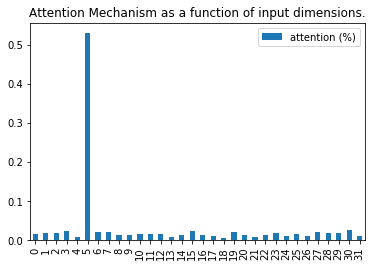

In [11]:
import numpy as np

#from attention_utils import get_activations, get_data

np.random.seed(1337)  # for reproducibility
from keras.models import *
from keras.layers import Input, Dense, merge

input_dim = 32


def build_model():
    inputs = Input(shape=(input_dim,))

    # ATTENTION PART STARTS HERE
    attention_probs = Dense(input_dim, activation='softmax', name='attention_vec')(inputs)
    attention_mul = merge([inputs, attention_probs], output_shape=32, name='attention_mul', mode='mul')
    # ATTENTION PART FINISHES HERE

    attention_mul = Dense(64)(attention_mul)
    output = Dense(1, activation='sigmoid')(attention_mul)
    model = Model(input=[inputs], output=output)
    return model


if __name__ == '__main__':
    N = 100000
    inputs_1, outputs = get_data(N, input_dim, attention_column=5)

    m = build_model()
    m.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    print(m.summary())

    m.fit([inputs_1], outputs, epochs=40, batch_size=32, validation_split=0.2)

    testing_inputs_1, testing_outputs = get_data(1, input_dim)

    # Attention vector corresponds to the second matrix.
    # The first one is the Inputs output.
    attention_vector = get_activations(m, testing_inputs_1,
                                       print_shape_only=True,
                                       layer_name='attention_vec')[0].flatten()
    print('attention =', attention_vector)

    # plot part.
    import matplotlib.pyplot as plt
    import pandas as pd

    pd.DataFrame(attention_vector, columns=['attention (%)']).plot(kind='bar',
                                                                   title='Attention Mechanism as '
                                                                         'a function of input'
                                                                         ' dimensions.')
    plt.show()

c:\users\a00439512\appdata\local\continuum\anaconda3\envs\demo\lib\site-packages\ipykernel_launcher.py:17: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
c:\users\a00439512\appdata\local\continuum\anaconda3\envs\demo\lib\site-packages\keras\legacy\layers.py:464: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
c:\users\a00439512\appdata\local\continuum\anaconda3\envs\demo\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=[<tf.Tenso...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 32)           0                                            
__________________________________________________________________________________________________
attention_vec (Dense)           (None, 32)           1056        input_8[0][0]                    
__________________________________________________________________________________________________
attention_mul (Merge)           (None, 32)           0           input_8[0][0]                    
                                                                 attention_vec[0][0]              
__________________________________________________________________________________________________
dense_15 (Dense)                (None, 64)           2112        attention_mul[0][0]              
__________

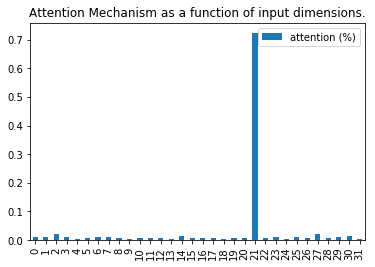

In [12]:
import numpy as np

#from attention_utils import get_activations, get_data

np.random.seed(1337)  # for reproducibility
from keras.models import *
from keras.layers import Input, Dense, merge

input_dim = 32


def build_model():
    inputs = Input(shape=(input_dim,))

    # ATTENTION PART STARTS HERE
    attention_probs = Dense(input_dim, activation='softmax', name='attention_vec')(inputs)
    attention_mul = merge([inputs, attention_probs], output_shape=32, name='attention_mul', mode='mul')
    # ATTENTION PART FINISHES HERE

    attention_mul = Dense(64)(attention_mul)
    output = Dense(1, activation='sigmoid')(attention_mul)
    model = Model(input=[inputs], output=output)
    return model


if __name__ == '__main__':
    N = 100000
    inputs_1, outputs = get_data(N, input_dim, attention_column=21)

    m = build_model()
    m.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    print(m.summary())

    m.fit([inputs_1], outputs, epochs=40, batch_size=32, validation_split=0.2)

    testing_inputs_1, testing_outputs = get_data(1, input_dim)

    # Attention vector corresponds to the second matrix.
    # The first one is the Inputs output.
    attention_vector = get_activations(m, testing_inputs_1,
                                       print_shape_only=True,
                                       layer_name='attention_vec')[0].flatten()
    print('attention =', attention_vector)

    # plot part.
    import matplotlib.pyplot as plt
    import pandas as pd

    pd.DataFrame(attention_vector, columns=['attention (%)']).plot(kind='bar',
                                                                   title='Attention Mechanism as '
                                                                         'a function of input'
                                                                         ' dimensions.')
    plt.show()